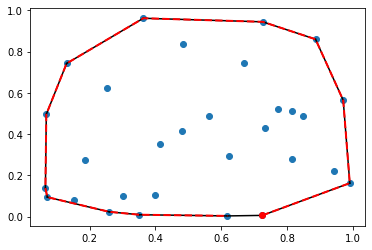

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pickle
import sys

def centroid_region(verticesSinglePoly):
    verticesSinglePoly = np.array(verticesSinglePoly)
    centroid  = np.sum(verticesSinglePoly, axis=0)/verticesSinglePoly.shape[0]
    return centroid

def plot_hull(points, hull, plotIndex=None):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if type(points[0]) is not list and type(points[0]) is not np.ndarray:
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(points[s, 0], points[s, 1], points[s, 2], "r-")

        ax.plot(points.T[0], points.T[1], points.T[2], "ko") 

    else:
        if(plotIndex == None):
            ran = range(len(points))
        else:
            ran = plotIndex
        for i in ran:
            points[i] = np.array(points[i])
            for s in hull[i].simplices:
                s = np.append(s, s[0])  # Here we cycle back to the first coordinate
                ax.plot(points[i][s, 0], points[i][s, 1], points[i][s, 2], "r-")

            ax.plot(points[i].T[0], points[i].T[1], points[i].T[2], "ko") 
            temp = centroid_region(points[i])
            ax.plot([temp[0]], [temp[1]], [temp[2]], 'go')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()


def get_conv_hull(points):
    # points = np.array([[0, 0, 0], [1, 1, 2] ,[1.5, 0.5, 1], [1.5, -0.5, 3], [1.25, 0.3, -1], [1, 0, 2], [1.25, -0.3, -1], [1, -1, 3]])
    
    if type(points[0]) is not list and type(points[0]) is not np.ndarray:
        hull = ConvexHull(points)
        faces = hull.simplices
    else:
        hull = []
        faces = []
        for i in range(len(points)):
            hull.append(ConvexHull(points[i]))
            faces.append((hull[i].simplices + 1).tolist())
    # np.savetxt(name_points, points, delimiter=",")
    # np.savetxt(name_hull, faces+1, delimiter=",")

    return hull, faces

def get_edges(shape_vertices):
    index = 0
    while index < len(shape_vertices):
        if index < len(shape_vertices) - 1:
            yield np.sort([shape_vertices[index], shape_vertices[index+1]])
        elif index == len(shape_vertices) - 1:
            yield np.sort([shape_vertices[-1], shape_vertices[0]])
        index += 1


def boarder_shape(s1, s2):
    for i1, e1 in enumerate(get_edges(s1)):
        for i2, e2 in enumerate(get_edges(s2)):
            if (np.sort(e1) == np.sort(e2)).all():
                # if (e1 == e2).all():
                #     inversed = False
                # else:
                #     inversed = True
                return [i1, i2]
    return [-1, -1]

def boarder_shape_b(s1, s2):
    for i1, e1 in enumerate(get_edges(s1)):
        for i2, e2 in enumerate(get_edges(s2)):
            if (np.sort(e1) == np.sort(e2)).all():
                # if (e1 == e2).all():
                #     inversed = False
                # else:
                #     inversed = True
                return True
    return False

def merge_shape(s1, s2):
    if type(s1) is np.ndarray:
        s1 = s1.tolist()
    pos = boarder_shape(s1, s2)
    if pos[1] == 0:
        s1.insert(pos[0] + 1, s2[2])
    elif pos[1] == 1:
        s1.insert(pos[0] + 1, s2[0])
    elif pos[1] == 2:
        s1.insert(pos[0] + 1, s2[1])
    else:
        print(str(s1) + ' ' + str(s2))
        return False
    return s1

def co_plane(s1, s2, vertices):
    pos = boarder_shape(s1, s2)
    p1_i, p2_i, p3_i = s1[0], s1[1], s1[2]

    if pos == [-1, -1]:
        return False

    if pos[1] == 0:
        p_i = s2[2]
    elif pos[1] == 1:
        p_i = s2[0]
    elif pos[1] == 2:
        p_i = s2[1]

    p1 = vertices[p1_i]
    p2 = vertices[p2_i]
    p3 = vertices[p3_i]
    p = vertices[p_i]

    # These two vectors are in the plane
    v1 = p3 - p1
    v2 = p2 - p1

    # the cross product is a vector normal to the plane
    cp = np.cross(v1, v2)
    a, b, c = cp

    # This evaluates a * x3 + b * y3 + c * z3 which equals d
    d = -np.dot(cp, p3)

    # print('The equation is {0}x + {1}y + {2}z = {3}'.format(a, b, c, d))

    # equation of plane is: a*x + b*y + c*z = 0 # 
      
    # checking if the 4th point satisfies 
    # the above equation 

    print(abs(a * p[0] + b * p[1] + c * p[2] + d))
    if(abs(a * p[0] + b * p[1] + c * p[2] + d) <= 10* sys.float_info.epsilon): 
        # print("True")
        return True
    else: 
        return False 

def put_in_set(i, sets_list):
    in_sets = False
    for sets in sets_list:
        if i in sets:
            sets.add(i)
            in_sets = True
    if not in_sets:
        sets_list.append({i})

def del_useless_edges(vor, hull):
    unique_edge_list = [[] for i in range(len(hull))]
    face_index_list = [[] for i in range(len(hull))]


    for macro_i in range(1):
        # i = 0

        # print(hull[0].simplices)
        hull_vertices = hull[macro_i].points

        tri_shapes = hull[macro_i].simplices
        poly_shapes = []

        for i in range(len(tri_shapes)):
            for j in range(i-1):
                if co_plane(tri_shapes[i], tri_shapes[j], hull_vertices):
                    in_sets = False
                    for sets in poly_shapes:
                        if i in sets or j in sets:
                            sets.add(i)
                            sets.add(j)
                            in_sets = True
                            break
                    if not in_sets:
                        poly_shapes.append({i, j})
                else:
                    put_in_set(i, poly_shapes)
                    put_in_set(j, poly_shapes)

        print('poly_shape ' + str(macro_i) + ': ' + str(poly_shapes))

        merge_to_shape = [tri_shapes[sets.pop()] for sets in poly_shapes]
        
        for i in range(len(merge_to_shape)):
            tri_left = list(poly_shapes[i])
            for j in range(len(tri_left)):
                index_to_pop = 0
                while not (boarder_shape_b(merge_to_shape[i], tri_shapes[tri_left[index_to_pop]])) and index_to_pop < len(tri_left):
                    index_to_pop += 1
                merge_to_shape[i] = merge_shape(
                    merge_to_shape[i], 
                    tri_shapes[tri_left.pop(index_to_pop)]
                )
            # merge_to_shape[i] = np.array(vor.regions[macro_i])[merge_to_shape[i]].tolist()
            merge_to_shape[i] = merge_to_shape[i]
        face_edge_list = []
        for i, shapes in enumerate(merge_to_shape):
            face_edge_list.append([])
            for j, edge in enumerate(get_edges(shapes)):
                unique_edge_list[macro_i].append(edge)
                face_edge_list[i].append(edge)
        unique_edge_list[macro_i] = np.unique(unique_edge_list[macro_i], axis=0).tolist()

        for i, face in enumerate(face_edge_list):
            face_index_list[macro_i].append([])
            for j, edge in enumerate(face):
                for k, unique_edge in enumerate(unique_edge_list[macro_i]):
                    if (edge == unique_edge).all():
                        face_index_list[macro_i][i].append(k) #= np.where(unique_edge_list[macro_i] == edge)[0]
                        break
        # print(unique_edge_list[macro_i])
        # print(merge_to_shape)

        # for i_tri, tri in enumerate(tri_shapes):
        #     for edge in get_edges(tri):
        #         for i_other_tri in range(i_tri):
        #             for other_edge in get_edges(tri_shapes[i_other_tri]):
        #                 if (edge == other_edge).all():
        #                     np.delete(tri_shapes, i_other_tri, 0)
        #                     print('found: ' + str(edge))
        #                     break

        # tri_shapes = np.concatenate((tri_shapes, np.expand_dims(tri_shapes[:,0], 1)), axis=1)
        # print(tri_shapes)

    return unique_edge_list, face_index_list

if __name__ == "__main__":
    points = np.random.rand(30, 2)   # 30 random points in 2-D
    hull = ConvexHull(points)

    import matplotlib.pyplot as plt
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
    plt.show()

In [4]:
a = [1,2,3,4]
b = [2,3,5]
boarder_shape(a, b)
print(merge_shape(a,b))

[1, 2, 5, 3, 4]
